In [201]:
# This Jupyter Notebook does feature engineering joining all features in all tables.

import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.naive_bayes import GaussianNB
from statsmodels.stats.outliers_influence import variance_inflation_factor

# We start analysis for the below period where attendance system is properly implemented at the given organization.
analysis_period_start_time = pd.to_datetime('2020-02-01 00:00:00')
analysis_period_end_time = pd.to_datetime('2022-12-31 23:59:59')

# Read employees dataset
df_employee_raw = pd.read_csv('data/employees4.csv', na_values=['\\N'], on_bad_lines='skip', infer_datetime_format=True, parse_dates=['Date_Joined', 'Date_Resigned', 'Inactive_Date'])
df_employee_raw.info()
print(f'Total employees {str(df_employee_raw["Employee_Code"].nunique())}')
print(f'Earliest join date {str(df_employee_raw["Date_Joined"].min())}')
print(f'Latest join date {str(df_employee_raw["Date_Joined"].max())}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Employee_No          1261 non-null   int64         
 1   Employee_Code        1261 non-null   int64         
 2   Name                 1261 non-null   object        
 3   Title                1261 non-null   object        
 4   Address_Line_1       1261 non-null   object        
 5   Address_Line_2       1181 non-null   object        
 6   Address_Line_3       952 non-null    object        
 7   Date_of_Birth        1261 non-null   object        
 8   Gender               1261 non-null   object        
 9   Religion_ID          1261 non-null   int64         
 10  Marital_Status       1170 non-null   object        
 11  Designation_ID       1261 non-null   int64         
 12  Date_Joined          1261 non-null   datetime64[ns]
 13  Date_Resigned        955 non-null

# Loading, Preprocessing and Descriptive Analysis

In [202]:
# Clean employee table
# Drop Employee_Code because it's not referenced in other tables.
# Other fields are dropped
df_employee = df_employee_raw.drop(['Employee_Code', 'Name', 'Address_Line_1', 'Address_Line_2', 'Address_Line_3',
                                    'Reporting_emp_1', 'Reporting_emp_2', 'Title', 'Religion', 'Religion_ID', 'Designation_ID'], axis=1)

date_range = (df_employee['Date_Joined'] >= analysis_period_start_time) & (df_employee['Date_Joined'] <= analysis_period_end_time)
df_employee = df_employee.loc[date_range]
df_employee

,Employee_No,Date_of_Birth,Gender,Marital_Status,Date_Joined,Date_Resigned,Status,Status_Reason,Inactive_Date,Employment_Category,Employment_Type,Designation
58,426,1962-05-10,Male,Married,2020-07-03,2021-10-26,Inactive,RESIGN,2021-10-26,Staff,Contarct Basis,Sociologist
73,450,1976-05-27,Male,Married,2020-12-03,2021-04-09,Inactive,RESIGN,2021-04-09,Labour,Contarct Basis,Unskilled Labor
78,457,1967-03-20,Male,Married,2020-06-01,NaN,Inactive,Resign,2020-09-25,Labour,Contarct Basis,Unskilled Labor
79,460,1955-03-10,Male,Married,2020-03-01,0000-00-00,Inactive,Resign,2020-03-31,Labour,Contarct Basis,Semi Skilled Labor
83,471,1992-08-16,Male,Single,2021-04-01,2022-02-28,Inactive,RESIGN,2022-02-28,Labour,Contarct Basis,Skilled Labor
...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2836,1993-03-23,Female,Single,2022-11-01,2022-12-22,Inactive,Resign,2022-12-22,Staff,Contarct Basis,Account Executive
1257,2890,1994-10-06,Male,Single,2022-11-21,0000-00-00,Active,NaN,0000-00-00,Staff,Contarct Basis,Quantity Surveyor
1258,2972,1997-01-02,Male,Single,2022-12-05,NaN,Active,NaN,NaN,Staff,Contarct Basis,Software Developer
1259,2973,1990-08-16,Male,Single,2022-12-08,0000-00-00,Active,NaN,0000-00-00,Staff,Contarct Basis,Quantity Surveyor


In [203]:
df_employee['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [204]:
df_employee['Marital_Status'].unique()

array(['Married', 'Single', nan], dtype=object)

In [205]:
df_employee['Date_Joined'].describe()

/tmp/ipykernel_210609/3760665125.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_employee['Date_Joined'].describe()


count                     796
unique                    369
top       2021-02-01 00:00:00
freq                       23
first     2020-02-01 00:00:00
last      2022-12-20 00:00:00
Name: Date_Joined, dtype: object

In [206]:
# Read leaves dataset, filter out special leave categories.
df_leaves = pd.read_csv('data/leaves_clean.csv')
df_leaves = df_leaves.rename(columns={'leave_date': 'Leave_Date',
                                      'Type': 'Leave_Factor',
                                      'Applied Date': 'Applied_Date',
                                      'leave_leave_date': 'Lieu_Leave_Date',
                                      'Remarks': 'Remarks',
                                      'apply_type': 'Leave_Category'})
df_leaves_type_map = {'Half Day': 0.5, 'Full Day': 1}
df_leaves['Leave_Factor'] = df_leaves['Leave_Factor'].map(df_leaves_type_map)
df_leaves_legit = pd.DataFrame(df_leaves.loc[(df_leaves['Leave_Category'] != 'Liue Leave') & (df_leaves['Leave_Category'] != 'Curfew') & (df_leaves['Leave_Category'] != 'Sat Holiday') & (df_leaves['Leave_Category'] != 'Special Leave')])
df_leaves_summary_temp = df_leaves.groupby('Employee_No')['Leave_Factor'].sum()
df_leaves_summary = pd.DataFrame({'Employee_No': df_leaves_summary_temp.index, 'Leave_Count':  df_leaves_summary_temp.values})
df_leaves_summary.head()
#df_leaves_summary

,Employee_No,Leave_Count
0,347,52.5
1,348,21.5
2,351,57.0
3,352,105.5
4,354,79.5


In [207]:
# Group two datasets

df_employee = pd.merge(df_employee, df_leaves_summary, on='Employee_No', how='left')
df_employee['Leave_Count'].fillna(0, inplace=True)
df_employee

,Employee_No,Date_of_Birth,Gender,Marital_Status,Date_Joined,Date_Resigned,Status,Status_Reason,Inactive_Date,Employment_Category,Employment_Type,Designation,Leave_Count
0,426,1962-05-10,Male,Married,2020-07-03,2021-10-26,Inactive,RESIGN,2021-10-26,Staff,Contarct Basis,Sociologist,11.0
1,450,1976-05-27,Male,Married,2020-12-03,2021-04-09,Inactive,RESIGN,2021-04-09,Labour,Contarct Basis,Unskilled Labor,60.0
2,457,1967-03-20,Male,Married,2020-06-01,NaN,Inactive,Resign,2020-09-25,Labour,Contarct Basis,Unskilled Labor,0.0
3,460,1955-03-10,Male,Married,2020-03-01,0000-00-00,Inactive,Resign,2020-03-31,Labour,Contarct Basis,Semi Skilled Labor,0.0
4,471,1992-08-16,Male,Single,2021-04-01,2022-02-28,Inactive,RESIGN,2022-02-28,Labour,Contarct Basis,Skilled Labor,73.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,2836,1993-03-23,Female,Single,2022-11-01,2022-12-22,Inactive,Resign,2022-12-22,Staff,Contarct Basis,Account Executive,5.0
792,2890,1994-10-06,Male,Single,2022-11-21,0000-00-00,Active,NaN,0000-00-00,Staff,Contarct Basis,Quantity Surveyor,9.0
793,2972,1997-01-02,Male,Single,2022-12-05,NaN,Active,NaN,NaN,Staff,Contarct Basis,Software Developer,4.0
794,2973,1990-08-16,Male,Single,2022-12-08,0000-00-00,Active,NaN,0000-00-00,Staff,Contarct Basis,Quantity Surveyor,2.0


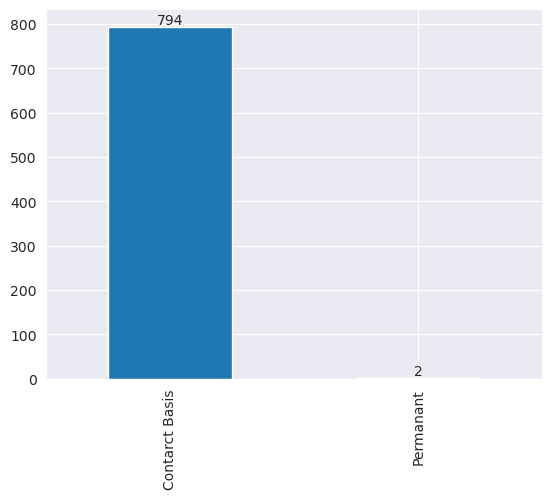

In [208]:
temp_plot = df_employee['Employment_Type'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee['Employment_Type'].value_counts())
plt.show()

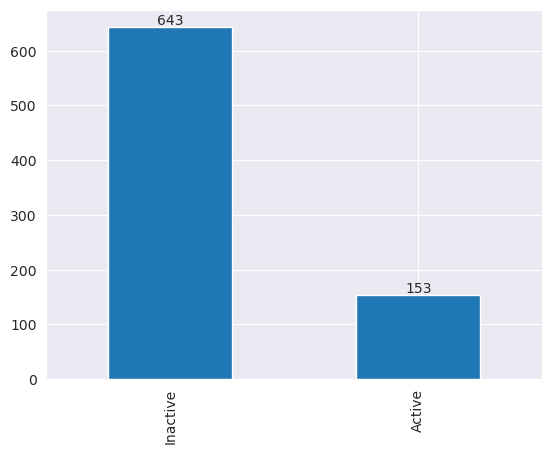

In [209]:
temp_plot = df_employee['Status'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee['Status'].value_counts())
plt.show()

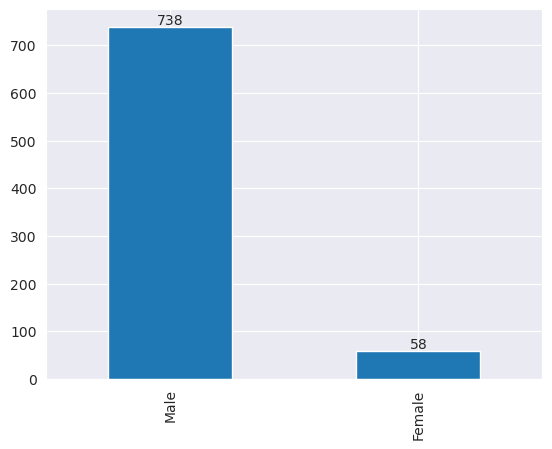

In [210]:
temp_plot = df_employee['Gender'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee['Gender'].value_counts())
plt.show()

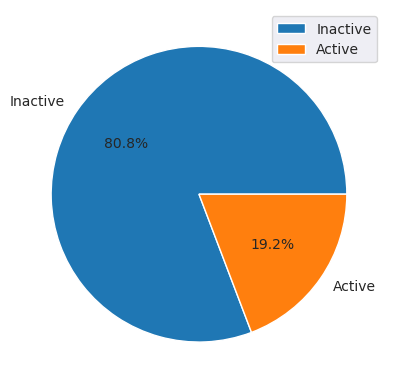

In [211]:
plt.pie(df_employee['Status'].value_counts(), labels=df_employee['Status'].unique(), autopct='%1.1f%%')
plt.legend()
plt.show()

In [212]:
# temp_plot = df_employee['Designation'].value_counts().plot(kind='pie')
# plt.legend()
# plt.show()

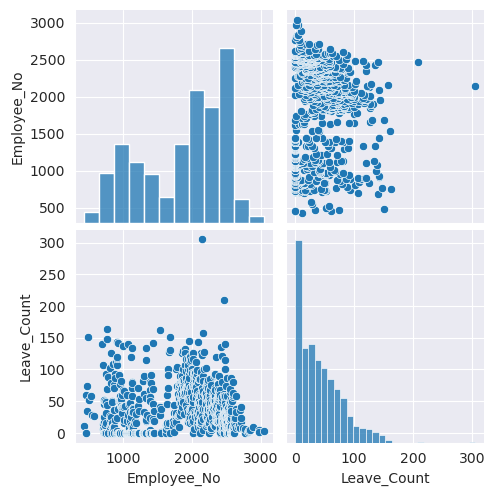

In [213]:
seaborn.pairplot(df_employee)

In [214]:
df_employee_inactive_contract_based = pd.DataFrame(df_employee.loc[(df_employee['Status'] == 'Inactive') & (df_employee['Employment_Type'] == 'Contarct Basis')])
df_employee_inactive_contract_based['Date_Joined'] = pd.to_datetime(df_employee_inactive_contract_based['Date_Joined'])
df_employee_inactive_contract_based['Date_Resigned'] = pd.to_datetime(df_employee_inactive_contract_based['Date_Resigned'], errors='coerce')
df_employee_inactive_contract_based['Employment_Duration'] = df_employee_inactive_contract_based['Date_Resigned'].fillna(df_employee_inactive_contract_based['Inactive_Date']) - df_employee_inactive_contract_based['Date_Joined'] + pd.Timedelta(days=1)
df_employee_inactive_contract_based = df_employee_inactive_contract_based.drop(df_employee_inactive_contract_based[df_employee_inactive_contract_based['Employment_Duration'] < pd.Timedelta(days=0)].index)
df_employee_inactive_contract_based['Unavailability_Factor'] = df_employee_inactive_contract_based['Leave_Count'] / df_employee_inactive_contract_based['Employment_Duration'].dt.days
df_employee_inactive_contract_based = df_employee_inactive_contract_based.drop(df_employee_inactive_contract_based[df_employee_inactive_contract_based['Unavailability_Factor'] >= 1].index)

# Annotating attrition or not. If the resignation date is a multiple of 1 year contract, we don't consider that as attrition.
df_employee_inactive_contract_based.loc[df_employee_inactive_contract_based['Employment_Duration'].dt.days % 365 == 0, 'Is_Attrition'] = 0
df_employee_inactive_contract_based.loc[df_employee_inactive_contract_based['Employment_Duration'].dt.days % 365 != 0, 'Is_Attrition'] = 1
df_employee_inactive_contract_based['Employment_Duration'].describe()

count                            603
mean     217 days 06:17:18.805970148
std      183 days 21:03:40.576458962
min                  1 days 00:00:00
25%                 81 days 00:00:00
50%                169 days 00:00:00
75%                296 days 00:00:00
max                933 days 00:00:00
Name: Employment_Duration, dtype: object

In [215]:
# Active contract base employee analysis.
from datetime import datetime
df_employee_active_contract_based = pd.DataFrame(df_employee.loc[(df_employee['Status'] == 'Active') & (df_employee['Employment_Type'] == 'Contarct Basis')])
df_employee_active_contract_based['Date_Joined'] = pd.to_datetime(df_employee_active_contract_based['Date_Joined'])
df_employee_active_contract_based['Employment_Duration'] = analysis_period_end_time - df_employee_active_contract_based['Date_Joined'] + pd.Timedelta(days=1)
df_employee_active_contract_based['Unavailability_Factor'] = df_employee_active_contract_based['Leave_Count'] / df_employee_active_contract_based['Employment_Duration'].dt.days
df_employee_active_contract_based = df_employee_active_contract_based.drop(df_employee_active_contract_based[df_employee_active_contract_based['Unavailability_Factor'] >= 1].index)
# Annotating active employees as non-attrition.
df_employee_active_contract_based['Is_Attrition'] = 0
df_employee_active_contract_based['Employment_Duration'].describe()

count                            152
mean     458 days 21:09:27.421052632
std      258 days 03:59:08.662802828
min                 12 days 23:59:59
25%                296 days 17:59:59
50%                368 days 11:59:59
75%                537 days 11:59:59
max               1065 days 23:59:59
Name: Employment_Duration, dtype: object

In [216]:
df_employee_inactive_contract_based['Leave_Count'].describe()

count    603.000000
mean      39.015755
std       34.120112
min        0.000000
25%        9.000000
50%       33.000000
75%       59.750000
max      163.000000
Name: Leave_Count, dtype: float64

In [217]:
df_employee_active_contract_based['Leave_Count'].describe()

count    152.000000
mean      55.019737
std       50.304565
min        0.000000
25%       12.500000
50%       49.250000
75%       82.375000
max      305.000000
Name: Leave_Count, dtype: float64

In [218]:
df_employee_inactive_contract_based['Unavailability_Factor'].describe()

count    603.000000
mean       0.227270
std        0.208634
min        0.000000
25%        0.050198
50%        0.201316
75%        0.333333
max        0.961538
Name: Unavailability_Factor, dtype: float64

In [219]:
df_employee_active_contract_based['Unavailability_Factor'].describe()

count    152.000000
mean       0.127464
std        0.112425
min        0.000000
25%        0.045296
50%        0.108324
75%        0.190642
max        0.626283
Name: Unavailability_Factor, dtype: float64

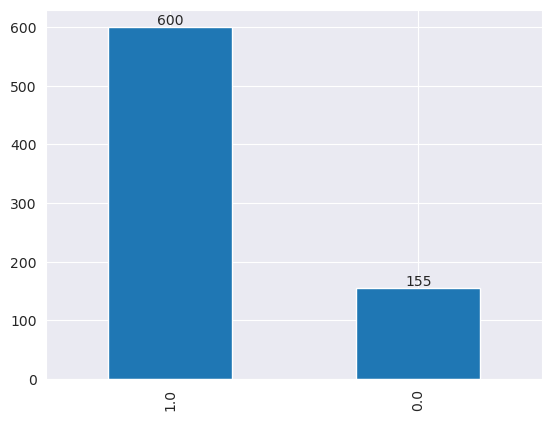

In [220]:
# Joining tables for attrition.
df_employee_for_modeling = pd.concat([df_employee_inactive_contract_based, df_employee_active_contract_based])
df_employee_for_modeling['Employment_Duration'] = df_employee_for_modeling['Employment_Duration'].dt.days
temp_plot = df_employee_for_modeling['Is_Attrition'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee_for_modeling['Is_Attrition'].value_counts())
plt.show()

Text(0, 0.5, 'Frequency')

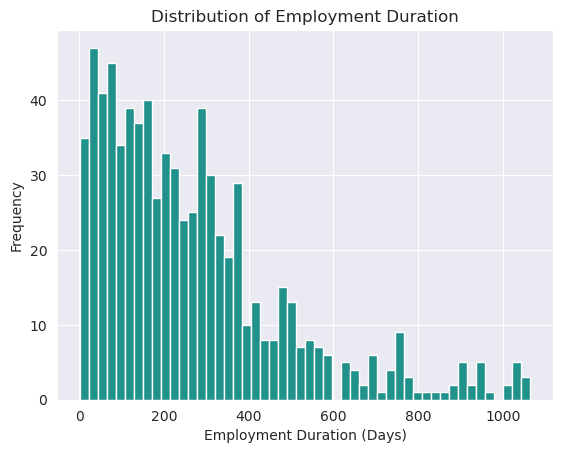

In [221]:
# Define a colormap
cmap = plt.cm.get_cmap('viridis')

# Plot the histogram with colored bars and axis labels
plt.hist(df_employee_for_modeling['Employment_Duration'], bins=50, color=cmap(0.5))
plt.title('Distribution of Employment Duration')
plt.xlabel('Employment Duration (Days)')
plt.ylabel('Frequency')

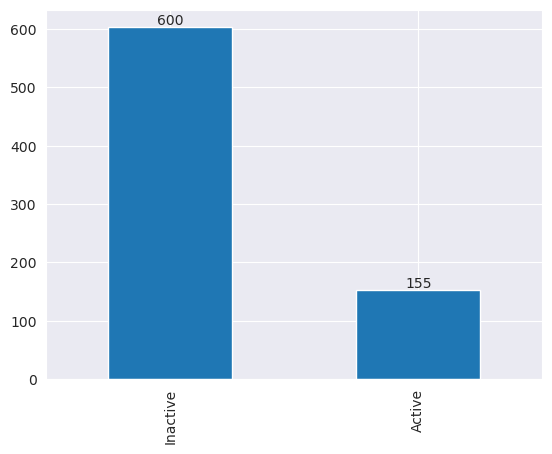

In [222]:
temp_plot = df_employee_for_modeling['Status'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee_for_modeling['Is_Attrition'].value_counts())
plt.show()

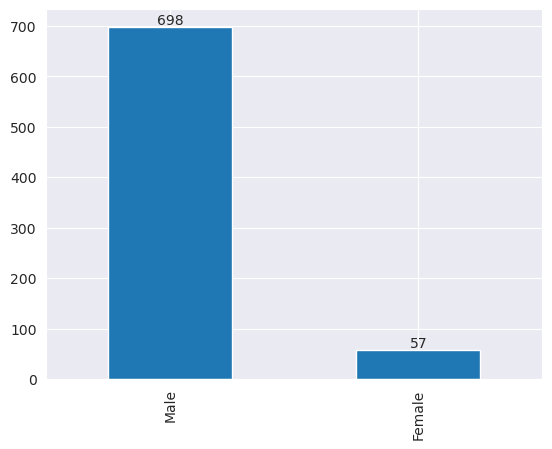

In [223]:
temp_plot = df_employee_for_modeling['Gender'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee_for_modeling['Gender'].value_counts())
plt.show()

In [224]:
gender_map = {'Female': 0, 'Male': 1}
material_status_map = {'Single': 0, 'Married': 1}
df_employee_for_modeling['Gender_Code'] = df_employee_for_modeling['Gender'].map(gender_map)
df_employee_for_modeling['Material_Status_Code'] = df_employee_for_modeling['Marital_Status'].map(material_status_map)
df_employee_for_modeling['Material_Status_Code'] = df_employee_for_modeling['Material_Status_Code'].fillna(2)

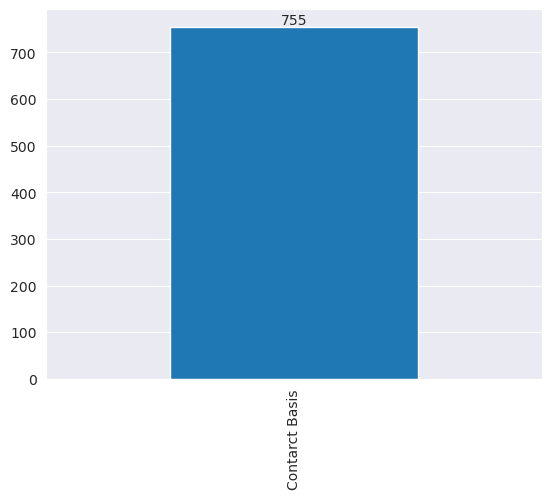

In [225]:
temp_plot = df_employee_for_modeling['Employment_Type'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee_for_modeling['Employment_Type'].value_counts())
plt.show()

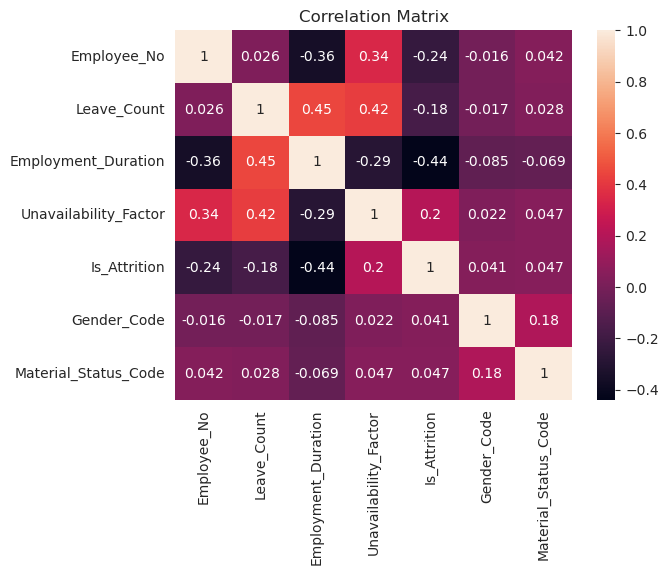

In [226]:
matrix = df_employee_for_modeling.corr()
seaborn.heatmap(matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

In [227]:
X_tentative = df_employee_for_modeling[['Gender_Code', 'Material_Status_Code', 'Employment_Duration', 'Leave_Count']]

In [228]:
df_vif = pd.DataFrame()
df_vif["Features"] = X_tentative.columns
df_vif["VIF Factor"] = [variance_inflation_factor(X_tentative.values, i) for i in range(X_tentative.shape[1])]
print(df_vif)

               Features  VIF Factor
0           Gender_Code    3.939213
1  Material_Status_Code    2.739031
2   Employment_Duration    2.828820
3           Leave_Count    2.736451


# Modeling

In [229]:
# Split the dataset into training and testing sets
X = scaler.fit_transform(X_tentative.astype(float))
y = df_employee_for_modeling['Is_Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)


## Logistic Regression

In [230]:
model = LogisticRegression()
fitted_model = model.fit(X_train, y_train)

In [231]:
lr_y_predicted = model.predict(X_test)

lr_accuracy = accuracy_score(y_test, lr_y_predicted)
print(f'Accuracy Leaner Regression: {lr_accuracy}')
lr_precision = precision_score(y_test, lr_y_predicted)
print(f'Precision: {lr_precision}')
lr_recall = recall_score(y_test, lr_y_predicted)
print(f'Recall: {lr_recall}')
lr_f1 = f1_score(y_test, lr_y_predicted)
print(f'F1 score: {lr_f1}')
lr_r2 = f1_score(y_test, lr_y_predicted)
print(f'R2 score: {lr_r2}')
lr_confusion_matrix = confusion_matrix(y_test, lr_y_predicted)
print(f'Confusion matrix: {lr_confusion_matrix}')

Accuracy Leaner Regression: 0.8013245033112583
Precision: 0.8333333333333334
Recall: 0.9426229508196722
F1 score: 0.8846153846153847
R2 score: 0.8846153846153847
Confusion matrix: [[  6  23]
 [  7 115]]


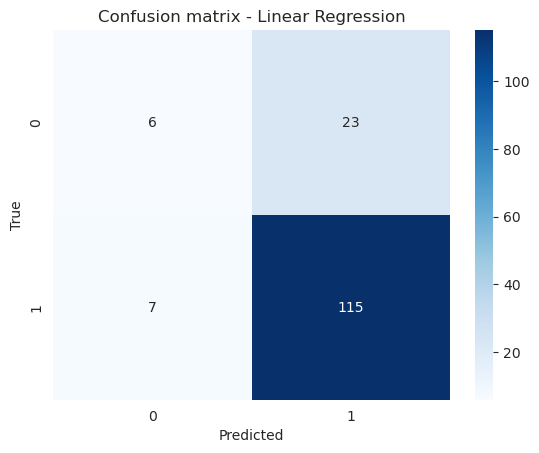

In [232]:
seaborn.heatmap(lr_confusion_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title('Confusion matrix - Linear Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## KNN

Minimum error:- 0.19205298013245034 at K = 4


/home/priyanka/etc/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/priyanka/etc/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

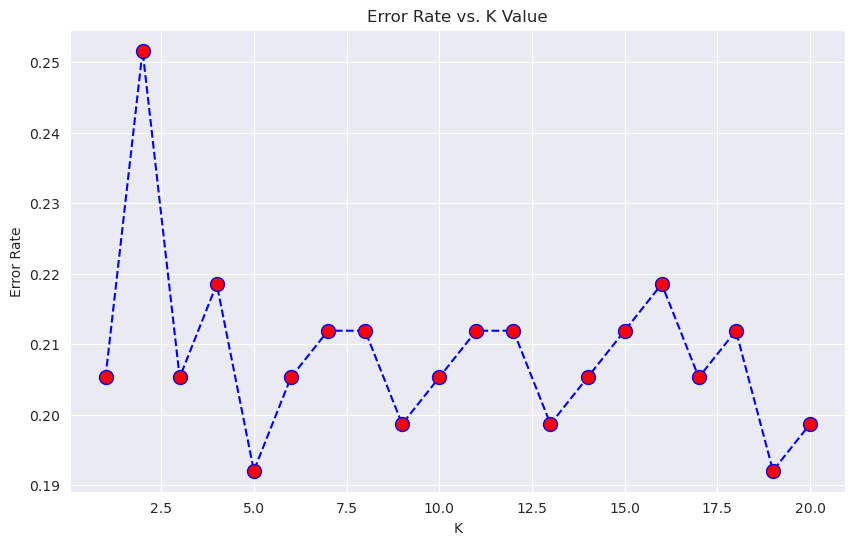

In [233]:

error_rate = []
for i in range(1,21):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train, y_train)
 knn_y_predicted = knn.predict(X_test)
 error_rate.append(np.mean(knn_y_predicted != y_test))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,21),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [234]:
#Train Model and Predict using KNN Classifier
k = 5
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
knn_Pred_y = neigh.predict(X_test)
print("Accuracy of model at K=8 is",metrics.accuracy_score(y_test, knn_Pred_y))

Accuracy of model at K=8 is 0.8079470198675497


/home/priyanka/etc/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [235]:
knn_accuracy = accuracy_score(y_test, knn_y_predicted)
print(f'Accuracy for KNN: {knn_accuracy}')
knn_precision = precision_score(y_test, knn_y_predicted)
print(f'Precision: {knn_precision}')
knn_recall = recall_score(y_test, knn_y_predicted)
print(f'Recall: {knn_recall}')
knn_f1 = f1_score(y_test, knn_y_predicted)
print(f'F1 score: {knn_f1}')
knn_r2 = r2_score(y_test, knn_y_predicted)
print(f'R2 score: {knn_r2}')

knn_confusion_matrix = confusion_matrix(y_test, knn_y_predicted)
print(f'Confusion matrix: {knn_confusion_matrix}')

Accuracy for KNN: 0.8013245033112583
Precision: 0.8484848484848485
Recall: 0.9180327868852459
F1 score: 0.8818897637795275
R2 score: -0.28038439796495185
Confusion matrix: [[  9  20]
 [ 10 112]]


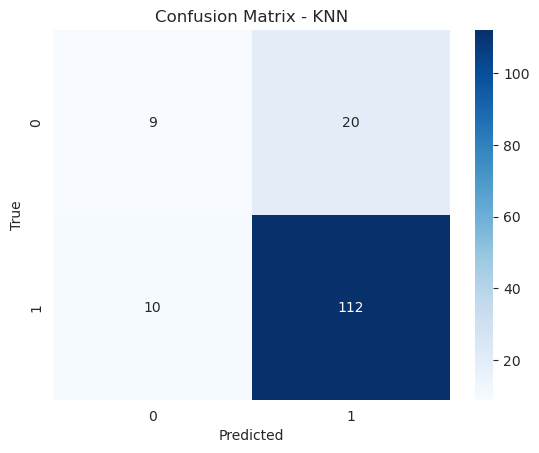

In [236]:
seaborn.heatmap(knn_confusion_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Naive Bayesian

In [237]:
# Create a Naive Bayes classifier and fit it to the training data
nb = GaussianNB()
nb.fit(X_train, y_train)

# Use the classifier to make predictions on the testing data
nb_y_predicted = nb.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, nb_y_predicted)
print("Accuracy:", accuracy)

Accuracy: 0.8013245033112583


In [238]:
nb_accuracy = accuracy_score(y_test, nb_y_predicted)
print(f'Accuracy for Naive Bayes: {nb_accuracy}')
nb_precision = precision_score(y_test, nb_y_predicted)
print(f'Precision: {nb_precision}')
nb_recall = recall_score(y_test, nb_y_predicted)
print(f'Recall: {nb_recall}')
nb_f1 = f1_score(y_test, nb_y_predicted)
print(f'F1 score: {nb_f1}')
nb_r2 = r2_score(y_test, nb_y_predicted)
print(f'R2 score: {nb_r2}')

nb_confusion_matrix = confusion_matrix(y_test, nb_y_predicted)
print(f'Confusion matrix: {nb_confusion_matrix}')

Accuracy for Naive Bayes: 0.8013245033112583
Precision: 0.859375
Recall: 0.9016393442622951
F1 score: 0.88
R2 score: -0.28038439796495185
Confusion matrix: [[ 11  18]
 [ 12 110]]


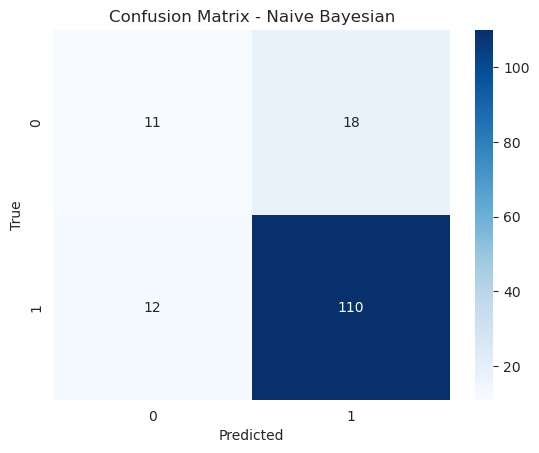

In [239]:
seaborn.heatmap(nb_confusion_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title('Confusion Matrix - Naive Bayesian')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Decision Tree

In [240]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier and fit it to the training data
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Use the classifier to make predictions on the testing data
dt_y_predicted = clf.predict(X_test)


In [241]:
dt_accuracy = accuracy_score(y_test, dt_y_predicted)
print(f'Accuracy for Decision Tree: {dt_accuracy}')
dt_precision = precision_score(y_test, dt_y_predicted)
print(f'Precision: {dt_precision}')
dt_recall = recall_score(y_test, dt_y_predicted)
print(f'Recall: {dt_recall}')
dt_f1 = f1_score(y_test, dt_y_predicted)
print(f'F1 score: {dt_f1}')
dt_r2 = r2_score(y_test, dt_y_predicted)
print(f'R2 score: {dt_r2}')

dt_confusion_matrix = confusion_matrix(y_test, dt_y_predicted)
print(f'Confusion matrix: {dt_confusion_matrix}')

Accuracy for Decision Tree: 0.8344370860927153
Precision: 0.888
Recall: 0.9098360655737705
F1 score: 0.8987854251012145
R2 score: -0.06698699830412647
Confusion matrix: [[ 15  14]
 [ 11 111]]


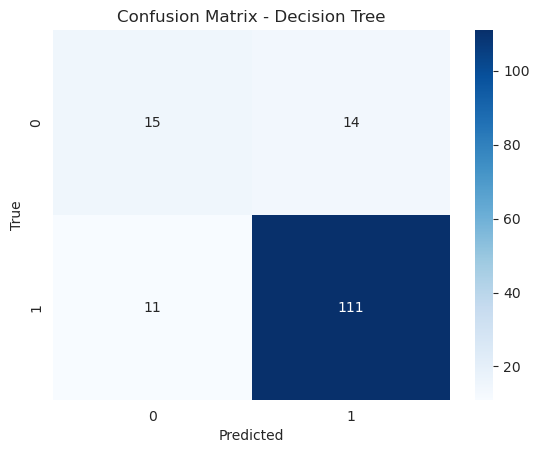

In [242]:
seaborn.heatmap(dt_confusion_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Random Forest

In [243]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_y_predicted = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_y_predicted)
print(f'Accuracy Rain Forest: {rf_accuracy}')
rf_precision = precision_score(y_test, rf_y_predicted)
print(f'Precision: {rf_precision}')
rf_recall = recall_score(y_test, rf_y_predicted)
print(f'Recall: {rf_recall}')
rf_f1 = f1_score(y_test, rf_y_predicted)
print(f'F1 score: {rf_f1}')
rf_r2 = r2_score(y_test, rf_y_predicted)
print(f'R2 score: {rf_r2}')

rf_confusion_matrix = confusion_matrix(y_test, rf_y_predicted)
print(f'Confusion matrix: {lr_confusion_matrix}')

Accuracy Rain Forest: 0.8344370860927153
Precision: 0.9008264462809917
Recall: 0.8934426229508197
F1 score: 0.897119341563786
R2 score: -0.06698699830412647
Confusion matrix: [[  6  23]
 [  7 115]]


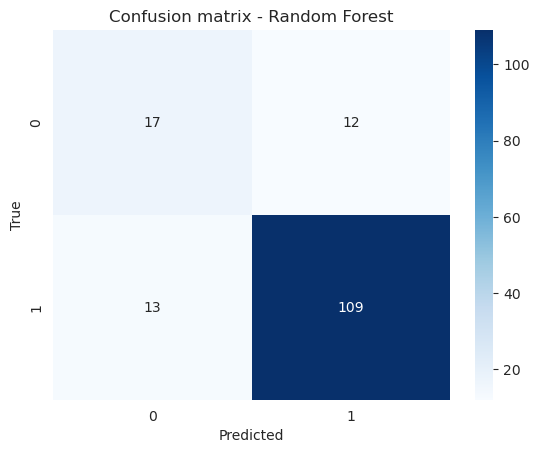

In [244]:
seaborn.heatmap(rf_confusion_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title('Confusion matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Polynomial Logistic Regression

Accuracy: 0.7947019867549668
Precision: 0.837037037037037
Recall: 0.9262295081967213
F1 score: 0.8793774319066149
R2 score: -0.3230638778971169
Confusion matrix: [[  7  22]
 [  9 113]]


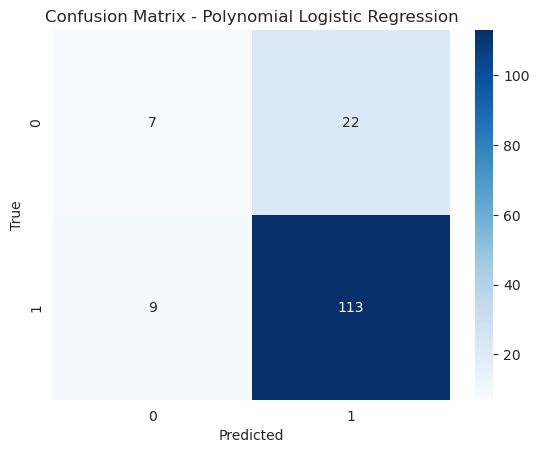

In [245]:
# Fit a Polynomial Logistic Regression model
pr_features = PolynomialFeatures(degree=2)
X_pr_train = pr_features.fit_transform(X_train)
X_pr_test = pr_features.fit_transform(X_test)
pr_model = LogisticRegression()
pr_model.fit(X_pr_train, y_train)

pr_y_predicted = pr_model.predict(X_pr_test)

pr_accuracy = accuracy_score(y_test, pr_y_predicted)
print(f'Accuracy: {pr_accuracy}')
pr_precision = precision_score(y_test, pr_y_predicted)
print(f'Precision: {pr_precision}')
pr_recall = recall_score(y_test, pr_y_predicted)
print(f'Recall: {pr_recall}')
pr_f1 = f1_score(y_test, pr_y_predicted)
print(f'F1 score: {pr_f1}')
pr_r2 = r2_score(y_test, pr_y_predicted)
print(f'R2 score: {pr_r2}')

pr_confusion_matrix = confusion_matrix(y_test, pr_y_predicted)
print(f'Confusion matrix: {pr_confusion_matrix}')

seaborn.heatmap(pr_confusion_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title('Confusion Matrix - Polynomial Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

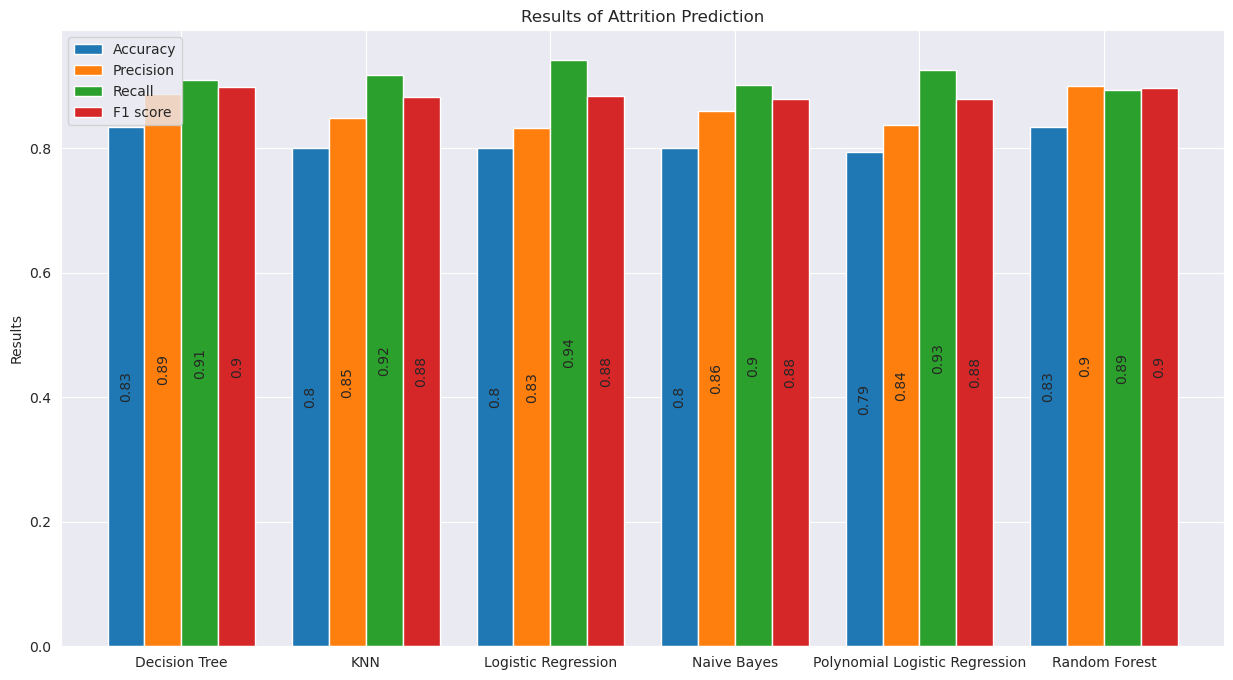

In [246]:
plotdata = pd.DataFrame({
    "Accuracy":[dt_accuracy, knn_accuracy, lr_accuracy, nb_accuracy, pr_accuracy, rf_accuracy],
    "Precision":[dt_precision, knn_precision, lr_precision, nb_precision, pr_precision, rf_precision],
    "Recall":[dt_recall, knn_recall, lr_recall, nb_recall, pr_recall, rf_recall],
    "F1 score":[dt_f1, knn_f1, lr_f1, nb_f1, pr_f1, rf_f1],
    # "R2 score":[dt_r2, knn_r2, lr_r2, nb_r2, pr_r2, rf_r2]
    },
    index=["Decision Tree", "KNN", "Logistic Regression", "Naive Bayes", "Polynomial Logistic Regression", "Random Forest"]
)

# Create the bar chart
ax = plotdata.plot(kind="bar", figsize=(15, 8), width=0.8)

# Set the chart title and labels
ax.set_title("Results of Attrition Prediction")
ax.set_ylabel("Results")
ax.set_xticklabels(plotdata.index, rotation=0)

# Add the value of y in the middle of each bar
for i in ax.containers:
    ax.bar_label(i, label_type="center", labels=[round(j.get_height(),2) for j in i], rotation=90)

# Show the plot
plt.show()

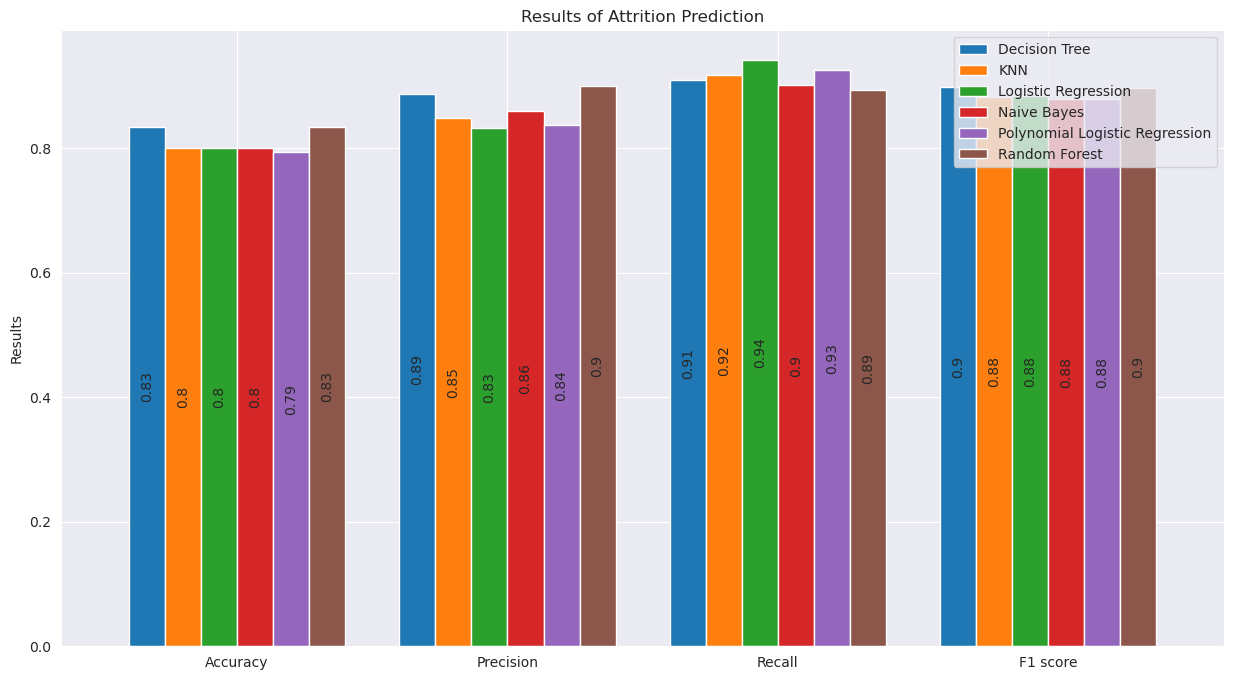

In [247]:
model_evaluation_metrics = pd.DataFrame({
    "Decision Tree": [dt_accuracy, dt_precision, dt_recall, dt_f1],
    "KNN": [knn_accuracy, knn_precision, knn_recall, knn_f1],
    "Logistic Regression": [lr_accuracy, lr_precision, lr_recall, lr_f1],
    "Naive Bayes": [nb_accuracy, nb_precision, nb_recall, nb_f1],
    "Polynomial Logistic Regression": [pr_accuracy, pr_precision, pr_recall, pr_f1],
    "Random Forest": [rf_accuracy, rf_precision, rf_recall, rf_f1]
},
    index=["Accuracy", "Precision", "Recall", "F1 score"]
)

# Create the bar chart
ax = model_evaluation_metrics.plot(kind="bar", figsize=(15, 8), width=0.8)

# Set the chart title and labels
ax.set_title("Results of Attrition Prediction")
ax.set_ylabel("Results")
ax.set_xticklabels(model_evaluation_metrics.index, rotation=0)

# Add the value of y in the middle of each bar
for i in ax.containers:
    ax.bar_label(i, label_type="center", labels=[round(j.get_height(),2) for j in i], rotation=90)

# Show the plot
plt.show()

In [248]:
## ROC curve

In [249]:
y_pred_knn = neigh.predict_proba(X_test)[:,1]
y_pred_pr = pr_model.predict_proba(X_pr_test)[:,1]
y_pred_nb = nb.predict_proba(X_test)[:,1]
y_pred_logistic = model.decision_function(X_test)
y_pred_random_forest = rf_model.predict_proba(X_test) [:,1]
y_pred_decision_tree = clf.predict_proba(X_test)[:,1]


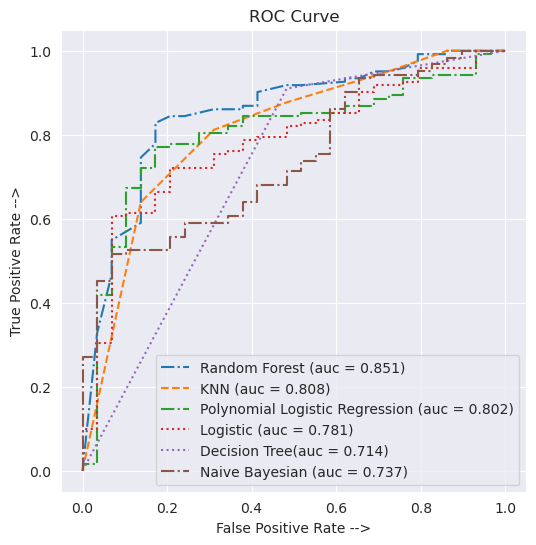

In [250]:
from sklearn.metrics import roc_curve, auc

logistic_fpr, logistic_tpr, threshold1 = roc_curve(y_test, y_pred_logistic)
auc_logistic = auc(logistic_fpr, logistic_tpr)

svm_fpr, svm_tpr, threshold1 = roc_curve(y_test, y_pred_random_forest)
auc_svm = auc(svm_fpr, svm_tpr)

dt_fpr, dt_tpr, threshold1 = roc_curve(y_test, y_pred_decision_tree)
auc_dt = auc(dt_fpr, dt_tpr)

nb_fpr, nb_tpr, threshold1 = roc_curve(y_test, y_pred_nb)
auc_nb = auc(nb_fpr, nb_tpr)

knn_fpr, knn_tpr, threshold5 = roc_curve(y_test, y_pred_knn)
auc_knn = auc(knn_fpr, knn_tpr)

pr_fpr, pr_tpr, threshold6 = roc_curve(y_test, y_pred_pr)
auc_pr = auc(pr_fpr, pr_tpr)


plt.figure(figsize=(6, 6), dpi=100)
plt.plot(svm_fpr, svm_tpr, linestyle='dashdot', label='Random Forest (auc = %0.3f)' % auc_svm)
plt.plot(knn_fpr, knn_tpr, linestyle='dashed', label='KNN (auc = %0.3f)' % auc_knn)
plt.plot(pr_fpr, pr_tpr, linestyle='dashdot', label='Polynomial Logistic Regression (auc = %0.3f)' % auc_pr)
plt.plot(logistic_fpr, logistic_tpr, linestyle='dotted', label='Logistic (auc = %0.3f)' % auc_logistic)
plt.plot(dt_fpr, dt_tpr, linestyle='dotted', label='Decision Tree(auc = %0.3f)' % auc_dt)
plt.plot(nb_fpr, nb_tpr, linestyle='dashdot', label='Naive Bayesian (auc = %0.3f)' % auc_nb)

plt.title("ROC Curve")
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()